In [1]:
import numpy as np
import pandas as pd
import os
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


(1365, 2048, 3)


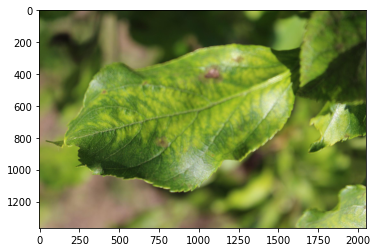

In [4]:
img = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
print(img.shape)
plt.imshow(img)

In [5]:
path='../input/plant-pathology-2020-fgvc7/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

train_paths = train.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values
test_paths = test.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values

train_labels = train.loc[:, 'healthy':].values

In [6]:
nb_classes = 4
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
img_size = 768
EPOCHS = 40
SEED = 123

In [7]:
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None, seed=2020):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
           
    if label is None:
        return image
    else:
        return image, label

In [8]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [9]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Learning rate schedule: 1e-05 to 0.0008 to 1.73e-05


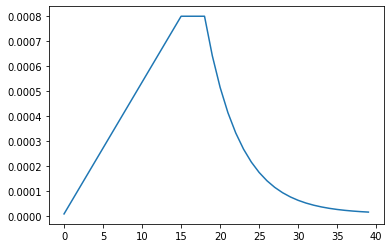

In [10]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [11]:
def get_model1():
    base_model =  efn.EfficientNetB7(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [12]:
def get_model2():
    base_model =  efn.EfficientNetB6(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [13]:
def get_model3():
    model = tf.keras.Sequential([
        ResNet152V2(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [14]:
def get_model4():
    model = tf.keras.Sequential([
        InceptionResNetV2(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [15]:
def get_model5():
    model = tf.keras.Sequential([
        InceptionV3(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [16]:
def get_model6():
    model = tf.keras.Sequential([
        Xception(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [17]:
def get_model7():
    model = tf.keras.Sequential([
        VGG19(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [18]:
with strategy.scope():
    model1 = get_model1()
    
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

258441216/258434480 [==============================] - 3s 0us/step


In [19]:
%%time
model1.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Train for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
28/28 [==============================] - 357s 13s/step - loss: 1.3432 - categorical_accuracy: 0.3973

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
Epoch 2/40
28/28 [==============================] - 28s 998ms/step - loss: 0.9263 - categorical_accuracy: 0.7321

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
Epoch 3/40
28/28 [==============================] - 34s 1s/step - loss: 0.3813 - categorical_accuracy: 0.8973

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
Epoch 4/40
28/28 [==============================] - 36s 1s/step - loss: 0.2819 - categorical_accuracy: 0.8884

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
Epoch 5/40
28/28 [==============================] - 37s 1s/step - loss: 0.2313 - categorical_accuracy: 0.9509

Epoch 00006: LearningRateSc

In [20]:
with strategy.scope():
    model2 = get_model2()
    
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

165527552/165527152 [==============================] - 2s 0us/step


In [21]:
%%time
model2.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Train for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
28/28 [==============================] - 266s 10s/step - loss: 1.3459 - categorical_accuracy: 0.4330

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
Epoch 2/40
28/28 [==============================] - 20s 732ms/step - loss: 0.9316 - categorical_accuracy: 0.7857

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
Epoch 3/40
28/28 [==============================] - 38s 1s/step - loss: 0.4077 - categorical_accuracy: 0.9107

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
Epoch 4/40
28/28 [==============================] - 40s 1s/step - loss: 0.2958 - categorical_accuracy: 0.8884

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
Epoch 5/40
28/28 [==============================] - 38s 1s/step - loss: 0.1942 - categorical_accuracy: 0.9286

Epoch 00006: LearningRateSc

In [22]:
with strategy.scope():
    model3 = get_model3()
    
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

234553344/234545216 [==============================] - 4s 0us/step


In [23]:
%%time
model3.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Train for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
28/28 [==============================] - 199s 7s/step - loss: 1.1882 - categorical_accuracy: 0.5402

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
Epoch 2/40
28/28 [==============================] - 15s 528ms/step - loss: 0.5061 - categorical_accuracy: 0.8616

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
Epoch 3/40
28/28 [==============================] - 37s 1s/step - loss: 0.2682 - categorical_accuracy: 0.8973

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
Epoch 4/40
28/28 [==============================] - 37s 1s/step - loss: 0.1853 - categorical_accuracy: 0.9375

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
Epoch 5/40
28/28 [==============================] - 38s 1s/step - loss: 0.1642 - categorical_accuracy: 0.9598

Epoch 00006: LearningRateSch

In [24]:
with strategy.scope():
    model4 = get_model4()
    
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

219062272/219055592 [==============================] - 2s 0us/step


In [25]:
%%time
model4.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Train for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
28/28 [==============================] - 219s 8s/step - loss: 1.3087 - categorical_accuracy: 0.4063

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
Epoch 2/40
28/28 [==============================] - 16s 558ms/step - loss: 0.5908 - categorical_accuracy: 0.8482

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
Epoch 3/40
28/28 [==============================] - 38s 1s/step - loss: 0.2977 - categorical_accuracy: 0.8795

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
Epoch 4/40
28/28 [==============================] - 38s 1s/step - loss: 0.1558 - categorical_accuracy: 0.9732

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
Epoch 5/40
28/28 [==============================] - 41s 1s/step - loss: 0.1707 - categorical_accuracy: 0.9375

Epoch 00006: LearningRateSch

In [26]:
#  strategy.scope():
#    model5 = get_model5()
    
# model5.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [27]:
# %%time
# model5.fit(
 #   train_dataset, 
  #  steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
 #   callbacks=[lr_callback],
 #   epochs=EPOCHS
# )

In [28]:
# with strategy.scope():
#     model6 = get_model6()
    
# model6.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [29]:
# %%time
# model6.fit(
#     train_dataset, 
#     steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
#     callbacks=[lr_callback],
#     epochs=EPOCHS
# )

In [30]:
# with strategy.scope():
#     model7 = get_model7()
    
# model7.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [31]:
# %%time
# model7.fit(
#     train_dataset, 
#     steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
#     callbacks=[lr_callback],
#     epochs=EPOCHS
# )

In [32]:
%%time
probs1 = model1.predict(test_dataset, verbose=1)
probs2 = model2.predict(test_dataset, verbose=1)
probs3 = model3.predict(test_dataset, verbose=1)
probs4 = model4.predict(test_dataset, verbose=1)
# probs5 = model5.predict(test_dataset, verbose=1)
# probs6 = model6.predict(test_dataset, verbose=1)
# probs7 = model7.predict(test_dataset, verbose=1)
probs_avg = (2*probs1 + probs2 + probs3 + probs4) / 5  # + probs5+ probs6 + probs7) / 8
sub.loc[:, 'healthy':] = probs_avg
sub.to_csv('submission_effnets.csv', index=False)
sub.head()

29/29 [==============================] - 69s 2s/step
CPU times: user 32.3 s, sys: 1.59 s, total: 33.9 s
Wall time: 5min 31s


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000001,0.000137,9.998612e-01,1.218583e-07
1,Test_1,0.000007,0.000941,9.990472e-01,5.007963e-06
2,Test_2,0.000001,0.000009,7.071714e-07,9.999886e-01
3,Test_3,0.999919,0.000004,2.576902e-05,5.093089e-05
4,Test_4,0.000028,0.001329,9.986069e-01,3.557085e-05
